## Testing glitch analysis

Here we will look at the posteriors probability samples created from running `paramestimation.sh`, which used `lalapps_pulsar_parameter_estimation_nested` before and after the fix described in [this MR](https://git.ligo.org/lscsoft/lalsuite/merge_requests/1211).

In [51]:
from lalinference.io import read_samples
from lalinference import LALInferenceHDF5PosteriorSamplesDatasetName

%matplotlib inline

import numpy as np
from matplotlib import pyplot as pl
import matplotlib as mpl

### Heterodyned data

First, let's look at the heterodyned data. The heterodyne has been performed twice; the first time taking into account the frequency offset caused by the glitch, but with no phase offset assumed (it was set to zero), and the second time assuming there was no glitch at all. The latter is just to show that taking the glitch into account for the heterodyne is required. From the plot below we can see that when we take account of the glitch frequency offset there is still a clear phase jump caused by the glitch, but otherwise the post glitch heterodyned data has the high frequency variation due to the glitch frequency offset removed.

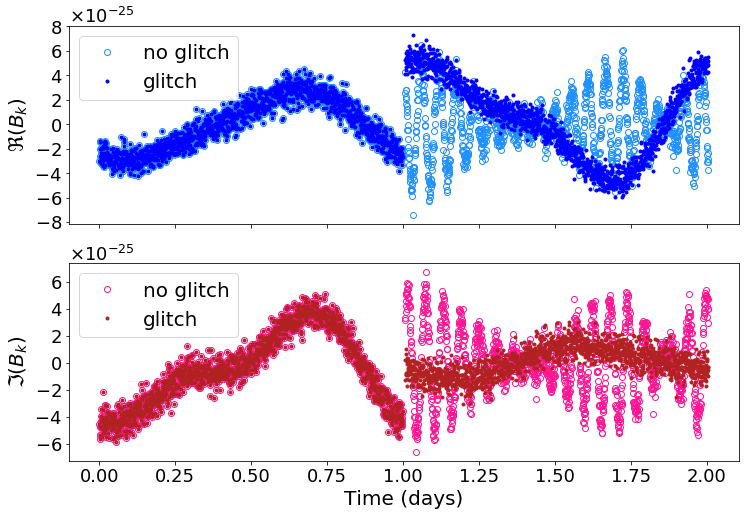

In [70]:
fine = np.loadtxt("fine_heterodyne_J0000+0000_H1.txt.gz", comments=["%"])
fineng = np.loadtxt("fine_heterodyne_J0000+0000_H1_noglitch.txt.gz", comments=["%"])  # heterodyned with the glitch ignored

rcparams = {
    "font.size": 20,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "font.family": "Times New Roman",
    "font.sans-serif": ["Bitstream Vera Sans"],
    "mathtext.fontset": "stixsans",
}

with mpl.rc_context(rcparams):
    fig, ax = pl.subplots(2, 1, figsize=(12, 8), sharex=True)

    ax[0].plot((fineng[:,0] - fineng[0,0])/86400, fineng[:,1], color="dodgerblue", marker="o", ls="none", mfc="none", label="no glitch")
    ax[0].plot((fine[:,0] - fine[0,0])/86400, fine[:,1], 'b.', label="glitch")
    ax[0].legend()

    ax[1].plot((fineng[:,0] - fineng[0,0])/86400, fineng[:,2], color="deeppink", marker="o", ls="none", mfc="none", label="no glitch")
    ax[1].plot((fine[:,0] - fine[0,0])/86400, fine[:,2], color="firebrick", marker='.', ls="none", label="glitch")
    ax[1].legend()
    
    ax[0].set_ylabel(r"$\Re{\left(B_k\right)}$")
    ax[1].set_ylabel(r"$\Im{\left(B_k\right)}$")
    ax[1].set_xlabel("Time (days)")
    
    ax[0].ticklabel_format(axis="y", style="sci", useMathText=True)
    ax[1].ticklabel_format(axis="y", style="sci", useMathText=True)

#### Source parameters

Now, let's looks the estimates of the source parameters. We will estimate the four gravitational-wave signal parameters $h_0$, $\phi_0$, $\cos{\iota}$ and $\psi$, which have injected values of $3\!\times\!10^{-24}$, 1 radian, 0.1, and 0.5 radians, respectively. We will also estimate the glitch phase offset, which was set to be 1 radian (for the equivalent EM signal).

First, we'll use the current "unfixed" version of `lalapps_pulsar_parameter_estimation_nested`.

Signal evidence: 318887.78333221
Recovered SNR: 141.0


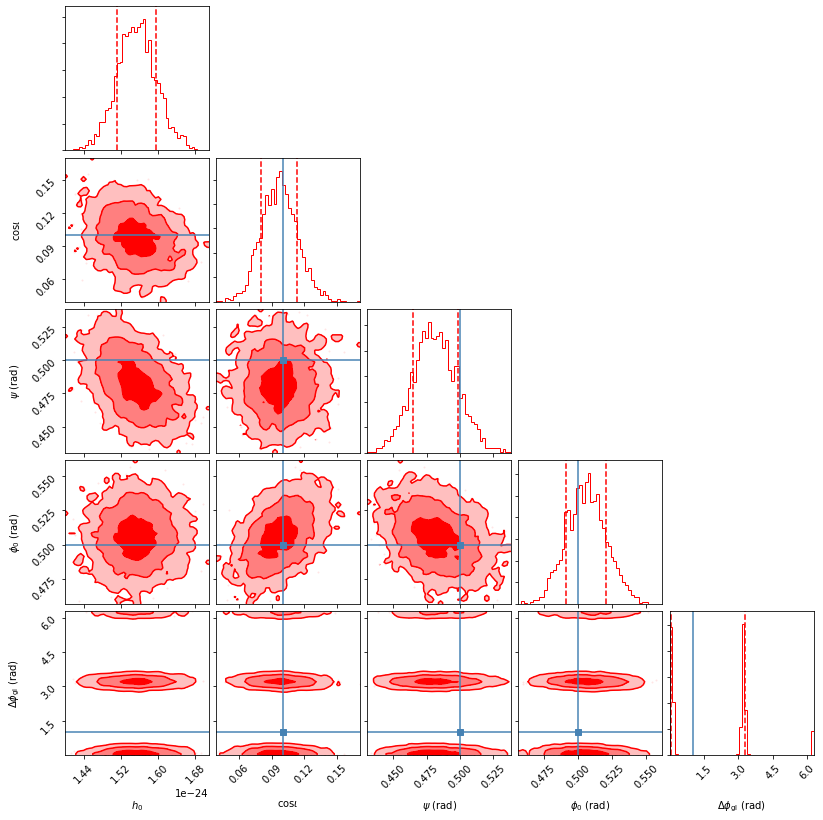

In [85]:
import corner
import h5py

post = read_samples(
    "post_old.hdf5",
    tablename=LALInferenceHDF5PosteriorSamplesDatasetName
)

samples = []
for param in ["H0", "COSIOTA", "PSI", "PHI0", "GLPH_1"]:
    if param == "GLPH_1":
        # convert glitch phase (with comes out in cycles, to radians)
        samples.append(post[param] * 2.0 * np.pi)
    else:
        samples.append(post[param])

truths=[3e-24, 0.1, 0.5, 0.5, 1.0]
labels=[r"$h_0$", r"$\cos{\iota}$", r"$\psi$ (rad)", r"$\phi_0$ (rad)", r"$\Delta\phi_{\rm gl}$ (rad)"]

# get the signal evidence
hdf = h5py.File("post_old.hdf5", "r")
a = hdf['lalinference']['lalinference_nest']
evsig = a.attrs['log_evidence']
hdf.close()

# get the recovered signal SNR
snr = float([line.split() for line in open("nest_old_SNR", "r").readlines() if line[0] != "#"][-1][-1])

fig = corner.corner(
    np.array(samples).T,
    color="r",
    bins=50,
    smooth=0.9,
    truths=truths,
    labels=labels,
    quantiles=[0.16, 0.84],
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.0)),
    fill_contours=True,
    hist_kwargs={"density": True},
)

print("Signal evidence: {0:.8f}".format(evsig))
print("Recovered SNR: {0:.1f}".format(snr))

From the above plot it can be seen that the recovered signal amplitude is only around half of what it should be and the recovered glitch phase is not correct.

Signal evidence: 325714.85595999
Recovered SNR: 276.5


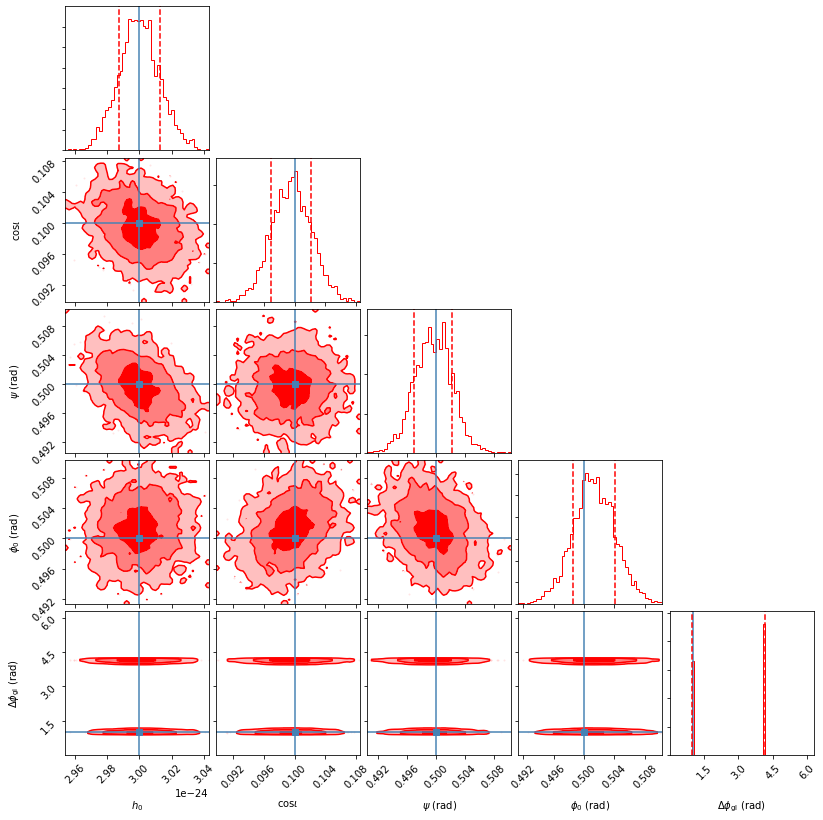

In [92]:
postnew = read_samples(
    "post_new.hdf5",
    tablename=LALInferenceHDF5PosteriorSamplesDatasetName
)

samplesnew = []
for param in ["H0", "COSIOTA", "PSI", "PHI0", "GLPH_1"]:
    if param == "GLPH_1":
        # convert glitch phase (with comes out in cycles, to radians)
        samplesnew.append(postnew[param] * 2.0 * np.pi)
    else:
        samplesnew.append(postnew[param])

# get the signal evidence
hdf = h5py.File("post_new.hdf5", "r")
a = hdf['lalinference']['lalinference_nest']
evsignew = a.attrs['log_evidence']
hdf.close()

# get the recovered signal SNR
snrnew = float([line.split() for line in open("nest_new_SNR", "r").readlines() if line[0] != "#"][-1][-1])

fig = corner.corner(
    np.array(samplesnew).T,
    color="r",
    bins=50,
    smooth=0.9,
    truths=truths,
    labels=labels,
    quantiles=[0.16, 0.84],
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.0)),
    fill_contours=True,
    hist_kwargs={"density": True},
)

ax = fig.get_axes()
ax[-1].set_xlim([0., 2.*np.pi])
for axs in ax[-5:-1]:
    axs.set_ylim([0., 2.*np.pi])

print("Signal evidence: {0:.8f}".format(evsignew))
print("Recovered SNR: {0:.1f}".format(snrnew))

In the above plot we see that the signal parameters are all recovered correctly, including the glitch phase offset (we get two modes seperated by $\pi$ radians due to the parameter estimation have a prior covering a full phase cycle for the EM phase, which is double the GW phase). We also see that the recovered SNR is about double the previous value.